In [1]:
import numpy as np
print(np.__version__)


import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

from tqdm.notebook import trange

import random
import math
print(torch.cuda.is_available())

1.23.5
2.0.0+cu117
True


In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from avalam_9x9 import *
from Self_Play_avalam_9x9 import *
from data_augmentation import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
board_size = 9*9 
rows = 9
columns = 9 
max_height = 5

## create dictionary to map actions from indices to action tuple type
def create_action_dictionary():
    action_dict = {}
    index = 0
    for row in range(rows):
        for col in range(columns):
            for drow in range(-1, 2):
                for dcol in range(-1, 2):
                    if drow == 0 and dcol == 0:
                        continue
                    new_row = row + drow
                    new_col = col + dcol
                    if 0 <= new_row < rows and 0 <= new_col < columns:
                        action_dict[(row, col, new_row, new_col)] = index
                        index += 1
    return action_dict

action_dict = create_action_dictionary()
index_to_action = {index: action for action, index in action_dict.items()}


initial_board = [ [ 0,  0,  1, -1,  0,  0,  0,  0,  0],
                    [ 0,  1, -1,  1, -1,  0,  0,  0,  0],
                    [ 0, -1,  1, -1,  1, -1,  1,  0,  0],
                    [ 0,  1, -1,  1, -1,  1, -1,  1, -1],
                    [ 1, -1,  1, -1,  0, -1,  1, -1,  1],
                    [-1,  1, -1,  1, -1,  1, -1,  1,  0],
                    [ 0,  0,  1, -1,  1, -1,  1, -1,  0],
                    [ 0,  0,  0,  0, -1,  1, -1,  1,  0],
                    [ 0,  0,  0,  0,  0, -1,  1,  0,  0] ]

actions_size = len(action_dict) 


1.23.5
2.0.0+cu117


In [3]:
import matplotlib.pyplot as plt

def plot_top_actions(top_actions, action_probs):
    """
    Plot the top action probabilities from the MCTS search.

    Args:
        top_actions (list): A list of action indices representing the top actions.
        action_probs (np.array): A numpy array containing the probabilities of each action.
    """
    top_probabilities = [action_probs[action_index] for action_index in top_actions]

    # Get the action coordinates from the action indices
    top_action_coordinates = [index_to_action[action_index] for action_index in top_actions]

    # Create the bar plot with top actions
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(top_actions)), top_probabilities)
    plt.xticks(range(len(top_actions)), top_action_coordinates, rotation=90)
    plt.xlabel('Top Actions (from_x, from_y, to_x, to_y)')
    plt.ylabel('Policy Probability')
    plt.title('Top Policy Probabilities')

    plt.show()

In [4]:
import matplotlib.pyplot as plt

def play_games(num_games, agent1, agent2, agent1_args=None, agent2_args=None):
    agent1_wins = 0
    agent2_wins = 0
    draws = 0

    for i in range(num_games):
        if i % 2 == 0:
            score = play_game(agent1, agent2, agent1_args, agent2_args, display=False)
        else:
            score = -play_game(agent2, agent1, agent2_args, agent1_args, display=False)

        if score > 0:
            agent1_wins += 1
        elif score < 0:
            agent2_wins += 1
        else:
            draws += 1

    return agent1_wins, agent2_wins, draws

### Load Model and check the action probabilites and value for a state

0.027524298056960106


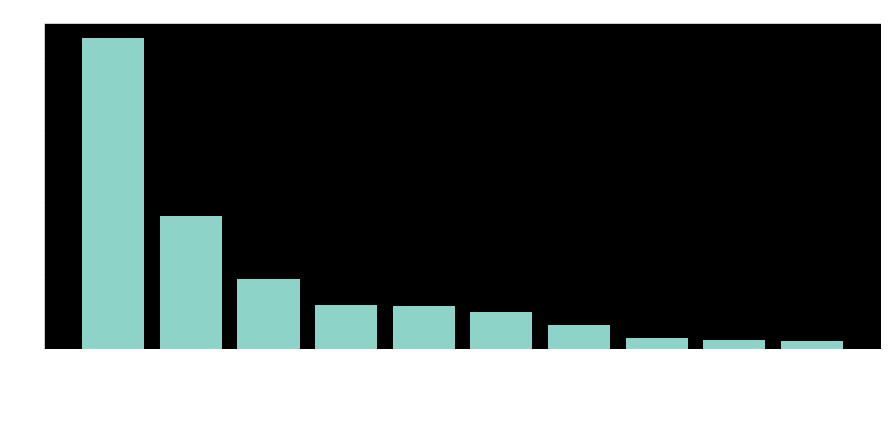

In [33]:
## state Encoding 
state =  np.array(  [ [ 0,  0,  3, -1,  0,  0,  0,  0,  0],
                      [ 0,  1, -1,  1,  0,  0,  0,  0,  0],
                      [ 0,  0,  1,  0,  0,  0, -4,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  4,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  5,  0,  0,  0,  0],
                      [ 0,  0, -5,  0,  0,  0,  0,  0,  0],
                      [ 0, -5,  0,  0,  0,  0,  5,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0] ])


# state = np.array(initial_state)
encoded_state = get_encoded_state_(state)
tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

## load Model and generate action probabilities and value state
model = ResNet( 6, 64, device=device, board_size = board_size, actions_size = actions_size)
model.load_state_dict(torch.load('model_supervised_big_model_final_0.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

#### adjust policy to only valid moves
valid_moves = np.zeros_like(policy)
for action_index in get_actions_indices_array(state, action_dict):
    valid_moves[action_index] = 1.0

policy *= valid_moves 
policy /= np.sum(policy)

## Plot action space
# Sort actions by their probabilities
sorted_actions = np.argsort(policy)[::-1]

# Select top 10 actions
top_actions = sorted_actions[:10]

# Plot the top 10 actions
plot_top_actions(top_actions, policy)

### 1.MCTS and Self Play

#### 1.1 MCTS

In [6]:
class MCTS() : 

    def __init__(self, model, args, device) :
        self.args = args
        self.model = model
 
        super().__init__()

    @torch.no_grad()
    def search(self, state):
#         define root 
        root = Node(self.args, state, visit_count=1)  ## board and state mean same thing 
        
        ## add noise 
        policy, _ = self.model(
                    torch.tensor(get_encoded_state_(state)).unsqueeze(0).to(device)
                )

        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * actions_size)
                
        valid_moves = np.zeros_like(policy)
        for action_index in get_actions_indices_array(state, action_dict):
            valid_moves[action_index] = 1.0
        
        policy *= valid_moves 
        policy /= np.sum(policy)
        root.expand(policy)

        for search in range(self.args["num_searches"]):
            ## Selection 
            node = root

            while node.is_fully_expanded():
                node = node.select()

            value, is_terminal = -get_score_array(node.board), is_finished_array(node.board)

            if not is_terminal: 
         
                policy, value = self.model(
                    torch.tensor(get_encoded_state_(node.board)).unsqueeze(0).to(device)
                ) 
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = np.zeros_like(policy)
                for action_index in get_actions_indices_array(node.board,action_dict):
                    valid_moves[action_index] = 1.0

                policy *= valid_moves 
                policy /= np.sum(policy)

                value = value.item()

                ## Expansion
                node = node.expand(policy)
                
            ## Backpropagation
            node.backpropagate(value)

        ## return visit counts 
        action_probs = [0] * actions_size

        for child in root.children:
            action_probs[child.action_taken] = child.visit_count

        total_visit_count = sum(action_probs)
        action_probs = np.array([prob / total_visit_count for prob in action_probs])
        return action_probs, root

class Node: 
    def __init__(self, args, board, parent=None, action_taken=None ,prior=0, visit_count=0):
        self.args = args 
        self.board = board 
        self.parent = parent 
        self.action_taken = action_taken 
        self.prior = prior  

        self.children = []
        self.expandable_moves = list(get_actions_indices_array(board, action_dict))

        self.visit_count = 0 
        self.value_sum = 0 


    def is_fully_expanded(self):
        return  len(self.children)>0 
    
    def select(self):
        best_child = None 
        best_ucb = -np.inf 

        for child in self.children : 
            ucb = self.get_ucb(child)
            if ucb > best_ucb :
                best_child = child 
                best_ucb = ucb 

        return best_child 
    
    def get_ucb(self, child):
        prior_score = child.prior * math.sqrt(self.visit_count) / (child.visit_count + 1)
        if child.visit_count > 0:
            value_score = child.value_sum / child.visit_count
        else:
            value_score = 0
        return value_score + prior_score

    def expand(self, policy):

        for action_ind, prob in enumerate(policy):
            if prob > 0 : 
                
                ## Store position of cells and their current height that will be impacted by the move , so we can undo the move 
                store_move = []
                action = index_to_action[action_ind]
                store_move.append((action[0] , action[1] , self.board[action[0]][action[1]])) 
                store_move.append((action[2] , action[3] , self.board[action[2]][action[3]]))

                ## play move 
                play_action_array(self.board,action)  

                ## change perspective 
                self.board = -1 * np.array(self.board)
                child_board = np.copy(self.board)
                child = Node(self.args, child_board, self, action_ind, prob)
                self.children.append(child)

                ## Undo the move is restoring the cells that were changed by their old state 
                self.board = -1 * self.board
                self.board[store_move[0][0]][store_move[0][1]] = store_move[0][2]
                self.board[store_move[1][0]][store_move[1][1]] = store_move[1][2]
                
        return child


    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = -value 
        if self.parent is not None:
            self.parent.backpropagate(value)  



Best action index: 65
Best action: (1, 3, 1, 2)


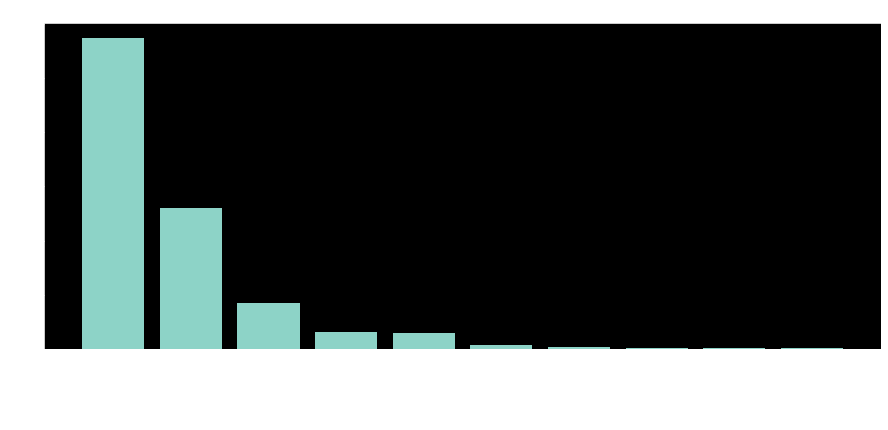

In [34]:
## state Encoding 
state =  np.array(  [ [ 0,  0,  3, -1,  0,  0,  0,  0,  0],
                      [ 0,  1, -1,  1,  0,  0,  0,  0,  0],
                      [ 0,  0,  1,  0,  0,  0, -4,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  4,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
                      [ 0,  0,  0,  0,  5,  0,  0,  0,  0],
                      [ 0,  0, -5,  0,  0,  0,  0,  0,  0],
                      [ 0, -5,  0,  0,  0,  0,  5,  0,  0],
                      [ 0,  0,  0,  0,  0,  0,  0,  0,  0] ])

# state = np.array(initial_state)
model = ResNet( 6, 64, device=device, board_size = board_size, actions_size = actions_size)
model.load_state_dict(torch.load('model_supervised_big_model_final_0.pt', map_location=device))
model.eval()


args = {
    'C': 1.25,
    'num_searches': 3000,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth' : 100
}

mcts = MCTS(model, args, device)

action_probs, root = mcts.search(state)

best_action_index = np.argmax(action_probs)
print("Best action index:", best_action_index)
best_action = index_to_action[best_action_index]
print("Best action:", best_action)

# Sort actions by their probabilities
sorted_actions = np.argsort(action_probs)[::-1]

# Select top 10 actions
top_actions = sorted_actions[:10]

# Plot the top 10 actions
plot_top_actions(top_actions, action_probs)

#### 1.2 Self Play

In [8]:
initial_state = [ [ 0,  0,  1, -1,  0,  0,  0,  0,  0],
                  [ 0,  1, -1,  1, -1,  0,  0,  0,  0],
                  [ 0, -1,  1, -1,  1, -1,  1,  0,  0],
                  [ 0,  1, -1,  1, -1,  1, -1,  1, -1],
                  [ 1, -1,  1, -1,  0, -1,  1, -1,  1],
                  [-1,  1, -1,  1, -1,  1, -1,  1,  0],
                  [ 0,  0,  1, -1,  1, -1,  1, -1,  0],
                  [ 0,  0,  0,  0, -1,  1, -1,  1,  0],
                  [ 0,  0,  0,  0,  0, -1,  1,  0,  0] ]

In [9]:
class AlphaZero():
    def __init__(self, model, optimizer, args):
        self.model = model 
        self.optimizer = optimizer 
        self.args = args 
        self.mcts = MCTS(model, args, device)
    
    def selfPlay(self):
        memory = []
        player = 1 
        state = np.copy(initial_state) ## initialize game state 

        while True :       
            action_probs, root = self.mcts.search(np.copy(state))
            
            memory.append((get_encoded_state_(state), action_probs, player))
            
            temperature_action_probs = np.array(action_probs) ** (1/self.args["temperature"])
            temperature_action_probs /= np.sum(temperature_action_probs)
            action_index = np.random.choice(actions_size, p=temperature_action_probs)  ## this action is scalar 
            action = index_to_action[action_index]
            
            ## get to next state using action 
            play_action_array(state,action) 

            value, is_terminal = get_score_array(state), is_finished_array(state)

            if is_terminal : 
                returnMemory = []
                for hist_neutral_state_encoded, hist_action_probs, hist_player in memory : 
                    hist_outcome = value * hist_player 
                    returnMemory.append((
                        hist_neutral_state_encoded, 
                        hist_action_probs, 
                        hist_outcome
                    ))
                return returnMemory
            
            ## change perspective 
            state = -1 * np.array(state)
            player *= -1
            
            

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            optimizer.step() # change to self.optimizer
            
            

    def learn(self):
        
        for iteration in range(self.args["num_iterations"]):
            memory = []

            self.model.eval()
            ## machine plays with itself 
            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]):
                memory += self.selfPlay()

            ## train based on the memory collected
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
                
            iteration += self.args["start_iteration"]
            torch.save(self.model.state_dict(), f"model_{iteration}.pt" )
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")
            return memory



In [ ]:
import time

model = ResNet( 3, 32, device=device, board_size = board_size, actions_size = actions_size)
# model.load_state_dict(torch.load('model_1.pt', map_location=device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer.load_state_dict(torch.load('optimizer_1.pt', map_location=device))

args = {
    'C': 2,
    'num_searches': 300,
    'num_iterations': 3,
    'start_iteration': 0,
    'num_parallel_games': 1,
    'num_selfPlay_iterations': 1,
    'num_epochs': 5,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, args)

start_time = time.time()
memory_ = alphaZero.learn()
end_time = time.time()

time_difference = end_time - start_time
print(f'The code took {time_difference:.2f} seconds to run.')


This part is to check the memory and if all is good 

In [ ]:
# for batchIdx in range(0, len(memory), args['batch_size']):
sample = memory_
states, policy_targets, value_targets = zip(*sample)

states, policy_targets, value_targets = np.array(states), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)


In [ ]:
for i in range(len(states)):
    
    print("state "+str(i)+" : score is : "+str(get_score_array(get_decoded_state(states[i])))
     + " number of moves : " + str(len(list(get_actions_indices_array(get_decoded_state(states[i]) , action_dict)))))
    print(get_decoded_state(states[i]))

#### 1.3Play against Random

In [10]:
model = ResNet( 3, 32, device=device, board_size = board_size, actions_size = actions_size)
# model.load_state_dict(torch.load('model_paral_2.pt', map_location=device))

args = {
    'C': 1.25,
    'num_searches': 500,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth':100
}
mcts = MCTS(model, args, device)
agent_args = {'model': model, 'mcts': mcts, 'args': args}


In [11]:
## Self Play agent
def self_play_agent(state, model, mcts, args, player):
    if model : 
        model.eval()
    action_probs, root = mcts.search(np.copy(state) * player)
    best_action_index = np.argmax(action_probs)
    best_action = index_to_action[best_action_index]
    return best_action

In [12]:
## random Agent
import random

def random_agent(state, player):
    valid_actions = [action for action in index_to_action.values() if is_action_valid_array(state, action)]
    return random.choice(valid_actions)


In [13]:
def play_game(agent1, agent2, agent1_args=None, agent2_args=None, display=True):
    if agent1_args is None:
        agent1_args = {}
    if agent2_args is None:
        agent2_args = {}

    state = np.array(initial_state)
    is_terminal = False
    move_number = 1
    score = 0

    while not is_terminal:
        if display:
            print(f"Move number {move_number}:")
            print("State:")
            print(state)
            print(f"Score: {score}")

        if move_number % 2 == 1:
            action = agent1(state, **agent1_args, player=1)
        else:
            action = agent2(state, **agent2_args, player=-1)

        play_action_array(state, action)
        score, is_terminal = get_score_array(state), is_finished_array(state)

        if display:
            print(f"Action played: {action}\n")

        move_number += 1

    if display:
        print("Final state:")
        print(state)
        print(f"Final score: {score}")

    return score


In [ ]:
## Generate Game between Self Play agent and Random
agent_args = {'model': model, 'mcts': mcts, 'args': args}

print("Game between self_play_agent and random_agent:")
play_game(self_play_agent, random_agent, agent1_args=agent_args)
# play_game(random_agent, self_play_agent, agent2_args=agent_args)

As we can see : Perfect result

#### 1.4 Play against Greedy Player 

In [14]:
def greedy_agent(state, player):
    actions = get_actions_array(state)
    
    def predict_score(state, action):
        new_state = play_action_array(state.copy(), action)
        i2, j2 = action[2], action[3]
        return  new_state[i2][j2]
    
    order = [player*5, player*4, player*3,player*2,player*1, player*-1,-player*2,-player*3, -player*4, -player*5]
    srt = {b: i for i, b in enumerate(order)}
    sorted_actions = sorted(actions, key=lambda a: srt[predict_score(state, a)])

    best_action = sorted_actions[0]

    return best_action


In [ ]:
print("\nGame between self_play_agent and greedy_agent:")
play_game(self_play_agent, greedy_agent, agent1_args=agent_args)
# play_game(greedy_agent, self_play_agent, agent2_args=agent_args)

In [ ]:
import matplotlib.pyplot as plt

def play_games(num_games, agent1, agent2, agent1_args=None, agent2_args=None):
    agent1_wins = 0
    agent2_wins = 0
    draws = 0

    for i in range(num_games):
        score = play_game(agent1, agent2, agent1_args, agent2_args, display=False)
        if score > 0:
            agent1_wins += 1
        elif score < 0:
            agent2_wins += 1
        else:
            draws += 1

    return agent1_wins, agent2_wins, draws

num_games = 20
agent1_args = {'model': model, 'mcts': mcts, 'args': args}

self_play_vs_random = play_games(num_games, self_play_agent, random_agent, agent1_args=agent1_args)
self_play_vs_greedy = play_games(num_games, self_play_agent, greedy_agent, agent1_args=agent1_args)

# Plotting results
x = np.arange(3)
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, self_play_vs_random, width, label='Self Play vs Random')
rects2 = ax.bar(x + width/2, self_play_vs_greedy, width, label='Self Play vs Greedy')

ax.set_ylabel('Number of Games')
ax.set_title('Self Play Agent Performance against Random and Greedy Agents')
ax.set_xticks(x)
ax.set_xticklabels(['Wins', 'Losses', 'Draws'])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


We can say that for mini-Avalam of size 3x3, we have already a very good model that can beat random player and Greedy player all the time 

### 2.Parallelization 

#### 2.1 MCTS

In [15]:
class MCTSParallel:

    def __init__(self, model, args, device):
        self.args = args
        self.model = model

        super().__init__()

    @torch.no_grad()
    def search(self, states, spGames):

        policy, _ = self.model(
            torch.tensor(get_encoded_states(states), device=self.model.device)
        )
        policy = torch.softmax(policy, axis=1).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * actions_size, size=policy.shape[0])

        for i, spg in enumerate(spGames):

            spg_policy = policy[i]
            valid_moves = np.zeros_like(spg_policy)
            for action_index in get_actions_indices_array(states[i], action_dict):
                valid_moves[action_index] = 1.0

            spg_policy *= valid_moves
            spg_policy /= np.sum(spg_policy)

            spg.root = Node(self.args, states[i], visit_count=1)
            spg.root.expand(spg_policy)

        for search in range(self.args["num_searches"]):
            for spg in spGames:
                spg.node = None
                node = spg.root

                while node.is_fully_expanded():
                    node = node.select()

                value, is_terminal = -get_score_array(node.board), is_finished_array(node.board)

                if is_terminal:
                    node.backpropagate(value)
                else:
                    spg.node = node

            expandable_spGames = [mappingIdx for mappingIdx in range(len(spGames)) if spGames[mappingIdx].node is not None]

            if len(expandable_spGames) > 0:
                states = np.stack([spGames[mappingIdx].node.board for mappingIdx in expandable_spGames])

                policy, value = self.model(
                    torch.tensor(get_encoded_states(states)).to(device)
                )
                policy = torch.softmax(policy, axis=1).cpu().numpy()
                value = value.cpu().numpy()

                for i, mappingIdx in enumerate(expandable_spGames):
                    node = spGames[mappingIdx].node
                    spg_policy, spg_value = policy[i], value[i].item()

                    valid_moves = np.zeros_like(spg_policy)
                    for action_index in get_actions_indices_array(node.board, action_dict):
                        valid_moves[action_index] = 1.0

                    spg_policy *= valid_moves
                    spg_policy /= np.sum(spg_policy)
                    
                    node.expand(spg_policy)
                    node.backpropagate(spg_value)


#### 2.2 Self Play

In [16]:
class AlphaZeroParallel():
    def __init__(self, model, optimizer, args):
        self.model = model
        self.optimizer = optimizer
        self.args = args
        self.mcts = MCTSParallel(model, args, device)

    def selfPlay(self):
        return_memory = []
        player = 1
        spGames = [SPG() for spg in range(self.args["num_parallel_games"])]

        while len(spGames) > 0:

            states = np.stack([spg.state for spg in spGames])
            

            self.mcts.search(states, spGames)

            for i in range(len(spGames))[::-1]:

                spg = spGames[i]

                ## return visit counts
                action_probs = np.zeros(actions_size)
                for child in spg.root.children:
                    action_probs[child.action_taken] = child.visit_count
                action_probs /= np.sum(action_probs)
                
                
                spg.memory.append((spg.state.copy(), action_probs, player))

                temperature_action_probs = action_probs ** (1 / self.args["temperature"])
                temperature_action_probs /= np.sum(temperature_action_probs)
                
                action_index = np.random.choice(actions_size, p=temperature_action_probs)
                action = index_to_action[action_index]

                ## get to the next state using action
                spg.state = play_action_array(spg.state, action)
                
                ## change perspective 
                spg.state *= -1 

                is_terminal = is_finished_array(spg.state)

                if is_terminal:
                    for hist_neutral_state, hist_action_probs, hist_player in spg.memory:
                        value = -get_score_array(spg.state) * hist_player 
                        hist_outcome = value
                        
                        ## Normal Training
#                         return_memory.append((
#                             get_encoded_state_(hist_neutral_state),
#                             hist_action_probs,
#                             hist_outcome
#                         ))
                        ### data augmentation 
                        combinations = generate_combinations(hist_neutral_state, hist_action_probs, hist_outcome)
                        return_memory.extend(combinations)
                
#                         return_memory.append(generate_combinations(hist_neutral_state, hist_action_probs, hist_outcome))
                    ## remove game after it's finished
                    del spGames[i]
        
                

            player *= -1

        return return_memory


    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            optimizer.step() # change to self.optimizer
            
            

    def learn(self):
        for iteration in range(self.args["num_iterations"] ):
            memory = []

            self.model.eval()
            ## machine plays with itself 
            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]//self.args["num_parallel_games"]):
                memory += self.selfPlay()

            ## train based on the memory collected
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
                
            iteration += self.args["start_iteration"]
            torch.save(self.model.state_dict(), f"model_paral_{iteration}.pt" )
            torch.save(self.optimizer.state_dict(), f"optimizer_paral_{iteration}.pt")
        return memory
            
class SPG:
    def __init__(self):
        self.state = np.copy(initial_state)
        self.memory = []
        self.root = None 
        self.node = None 
        


#### 2.3 Training

In [ ]:
import time

model = ResNet( 3, 32, device=device, board_size = board_size, actions_size = actions_size)
# model.load_state_dict(torch.load('model_paral_2.pt', map_location=device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer.load_state_dict(torch.load('optimizer_paral_2.pt', map_location=device))

args = {
    'C': 2,
    'num_searches': 500,
    'num_iterations': 1,
    'start_iteration': 3, ### DONT FORGET 
    'num_parallel_games': 50,
    'num_selfPlay_iterations': 50,
    'num_epochs': 5,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth':100
}

alphaZero = AlphaZeroParallel(model, optimizer, args)

start_time = time.time()
memory = alphaZero.learn()
end_time = time.time()

time_difference = end_time - start_time
print(f'The code took {time_difference:.2f} seconds to run.')

In [ ]:
# for batchIdx in range(0, len(memory), args['batch_size']):
sample = memory
states, policy_targets, value_targets = zip(*sample)

states, policy_targets, value_targets = np.array(states), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)

In [ ]:
for i in range(len(states)):
    
    print("state "+str(i)+" : score is : "+str(get_score_array(get_decoded_state(states[i])))
     + " number of moves : " + str(len(list(get_actions_indices_array(get_decoded_state(states[i]) , action_dict)))))
    print(get_decoded_state(states[i]))

In [ ]:
for v in value_targets :
    print(v[0])

#### 2.4 Play against older version

In [ ]:
model_1 = ResNet( 3, 32, device=device, board_size = board_size, actions_size = actions_size)
# model_1.load_state_dict(torch.load('model_paral_2.pt', map_location=device))

model_2 = ResNet( 3, 32, device=device, board_size = board_size, actions_size = actions_size)
# model_2.load_state_dict(torch.load('model_paral_1.pt', map_location=device))

args = {
    'C': 1.25,
    'num_searches': 1500,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth': 100
}
mcts_1 = MCTS(model_1, args, device)
mcts_2 = MCTS(model_2, args, device)

agent1_args = {'model': model_1, 'mcts': mcts_1, 'args': args}
agent2_args = {'model': model_2, 'mcts': mcts_2, 'args': args}

In [ ]:
print("\nGame between self_play_agent_v1 and self_play_agent_v2")
# play_game(self_play_agent, greedy_agent, agent1_args=agent1_args)
# play_game(greedy_agent, self_play_agent, agent2_args=agent1_args)
play_game(self_play_agent, self_play_agent, agent1_args=agent1_args, agent2_args=agent2_args)
play_game(self_play_agent, self_play_agent, agent1_args=agent2_args, agent2_args=agent1_args)

#### 2.5 PLay against Greedy 

In [ ]:
model = ResNet( 3, 32, device=device, board_size = board_size, actions_size = actions_size)
model.load_state_dict(torch.load('model_paral_3.pt', map_location=device))

args = {
    'C': 1.25,
    'num_searches': 2000,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth':5
}
agent_args = {'model': model, 'mcts': mcts, 'args': args}
mcts = MCTS(model, args, device)


In [ ]:
print("\nGame between self_play_agent and greedy_agent:")
# play_game(self_play_agent, greedy_agent, agent1_args=agent_args)
play_game(greedy_agent, self_play_agent, agent2_args=agent_args)

In [ ]:
import matplotlib.pyplot as plt

def play_games(num_games, agent1, agent2, agent1_args=None, agent2_args=None):
    agent1_wins = 0
    agent2_wins = 0
    draws = 0

    for i in range(num_games):
        score = play_game(agent1, agent2, agent1_args, agent2_args, display=False)
        if score > 0:
            agent1_wins += 1
        elif score < 0:
            agent2_wins += 1
        else:
            draws += 1

    return agent1_wins, agent2_wins, draws

num_games = 5
# agent1_args = {'model': model, 'mcts': mcts, 'args': args}

self_play_vs_random = play_games(num_games, self_play_agent, random_agent, agent1_args=agent_args)
self_play_vs_greedy = play_games(num_games, self_play_agent, greedy_agent, agent1_args=agent_args)

# Plotting results
x = np.arange(3)
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, self_play_vs_random, width, label='Self Play vs Random')
rects2 = ax.bar(x + width/2, self_play_vs_greedy, width, label='Self Play vs Greedy')

ax.set_ylabel('Number of Games')
ax.set_title('Self Play Agent Performance against Random and Greedy Agents')
ax.set_xticks(x)
ax.set_xticklabels(['Wins', 'Losses', 'Draws'])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


In [ ]:
self_play_vs_greedy

### 3.Training using Pre-built agents 

#### 3.1 Heuristics Used

In [17]:
def get_actions_ranked (board , limit_moves ,max_player): 
    """Yield all valid actions on this board."""
    
    scores = []
    actions = []

    towers = get_towers_array(board)
    towers_position = {(x,y) for x,y,z in towers}
    
    
    for i, j, h in get_towers_array(board):
        for action in get_tower_actions_array(board, i, j):
            i1, j1, i2, j2 = action
            h1 = abs(board[i1][j1])
            h2 = abs(board[i2][j2])

            score = 0 
            visited = {}
            
            ###### Heuristic 1 for Isolate Pawns :
            ## Store position of cells and their current height that will be impacted by the move , so we can undo the move 
            store_move = []
            store_move.append(( i1, j1 , board[i1][j1])) 
            store_move.append(( i2, j2 , board[i2][j2]))

            # play action on board
            play_action_array(board, action) 

            # check if move yielded isolated pawns (neighbors of (i,j)cell)
            for i_ in range(i1-1 , i1+2, 1) :
                for j_ in range(j1-1, j1+2 ,1) :
                    if (i_,j_) in towers_position : 
                        if not is_tower_movable_array(board,i_, j_) and board[i_][j_] != 0 and abs(board[i_][j_]) != 5 :
                            visited[(i,j)] = True
                            score += 3 * board[i_][j_] / abs(board[i_][j_] )    

            
            ## Undo the move is restoring the cells that were changed by their old state 
            board[store_move[0][0]][store_move[0][1]] = store_move[0][2]
            board[store_move[1][0]][store_move[1][1]] = store_move[1][2]
            ########


            ###### Heuristic 2 : If Move result on tours with heigher weight 
            if board[i1][j1] < 0 and (i,j) not in visited: ## yellow on top
                score += -(h1 + h2)
            elif board[i1][j1] > 0 and (i,j) not in visited :
                score += h1 + h2

            ###### Heuristic 3: Moves where you put your own stone on top of another yours is generally weak
            if  board[i1][j1] * board[i2][j2] >= 1 :
                score -= 2.5 * board[i1][j1] / abs(board[i1][j1] )

            # store new score resulted from the action 
            scores.append(score)
            actions.append(action) 
            
    # Normalize scores to probabilities
    min_score = min(scores)
    max_score = max(scores)
    if max_score == min_score:  # to avoid division by zero
        probs = [1 / len(scores)] * len(scores)
    else:
        if max_player == -1:
            scores = [-score for score in scores]  # flip scores for max_player == -1
        probs = [(score - min_score) / (max_score - min_score) for score in scores]

    return sorted(zip(actions, probs), key=lambda x: x[1], reverse=True)[:limit_moves]


In [18]:
def score_board(board  ):
        
    score = 0
    visited = set()


    for i in range(rows):
        for j in range(columns):
            
            if board[i][j] == 0 :
                pass
            
            ## assign 1.55 points to Tour 
            elif board[i][j] in (-max_height,max_height) :
                score += 1.55 * board[i][j] / abs(board[i][j] )

            ## assign 3 points to isolated Powns 
            elif not is_tower_movable_array(board, i, j):
                score += 1.5 * board[i][j] / abs(board[i][j] )
                
            ## assign 1 point to the rest of the Pawns if not isolated group of pawns , otherwise assign the correct value as explained in the report 
            else :
                ## if already visited assign one point to that pawn 
                if (i,j) in visited :
                    score += board[i][j] / abs(board[i][j] )
                
                ## if never visited , check the existence of isolated group of pawns 
                else :
                    color = board[i][j] / abs(board[i][j] )
                    cycle = [(i,j)]
                    cycle_sum = max_height - abs(board[i][j])
                    same_color = True 
                    nodes_visited = -1 

                    
                    while ( cycle_sum >= 0 and cycle != [] and same_color ) :

                        current = cycle.pop()

                         ## look neighbors 
                        for action in get_tower_actions_array(board, current[0] , current[1]):               
                            i1, j1, i2, j2 = action
                            ## if same color , continue 
                            if board[i2][j2] / abs(board[i2][j2] ) != color :
                                same_color = False 
                                
                            if current not in visited : 
                                cycle.append((i2,j2))
                                visited.add((i2,j2))
                                cycle_sum -= abs(board[i2][j2])
                        
                        nodes_visited += 1 

                    ## if already more than 5 or color is changed , assign one point . 
                    if cycle != [] or same_color == False : 
                        score += board[i][j] / abs(board[i][j] ) 

                    ## if its one group isolated of pawns , assign 1.55 if their sum is 5 (equivalent to 1 Tour ) 
                    ## and 1.5 if their sum is less than 5 (Equivalent to isolated pawn)   
                    else : 
                        if cycle_sum == 3 : 
                            score += 1.55 * color - nodes_visited * 1 * color 
                        else :
                            score += 1.5 * color - nodes_visited * 1 * color 
                    
                
    return score 
    

#### 3.2 MCTS

In [19]:
class MCTS_Supervised() : 

    def __init__(self, args, device) :
        self.args = args
 
        super().__init__()

    @torch.no_grad()
    def search(self, state):
#         define root 
        root = Node(self.args, state, visit_count=1)  ## board and state mean same thing 
        
        value = score_board(root.board)


        action_probs = get_actions_ranked(root.board, 20, 1) ## get list of actions ranked with probabilities

        policy = np.zeros(actions_size)
        for action, prob in action_probs:
                action_index = action_dict[action]
                policy[action_index] = prob
        
        root.expand(policy)

        for search in range(self.args["num_searches"]):
            ## Selection 
            node = root

            while node.is_fully_expanded():
                node = node.select()

            value, is_terminal = -get_score_array(node.board), is_finished_array(node.board)

            if not is_terminal: 
         
                value = score_board(node.board)

                policy = np.zeros(9*9*8)

                action_probs = get_actions_ranked(node.board, 20, 1) ## get list of actions ranked with probabilities

                policy = np.zeros(9*9*8)
                for action, prob in action_probs:
                    action_index = action_dict[action]
                    policy[action_index] = prob

                ## Expansion
                node = node.expand(policy)
                
            ## Backpropagation
            node.backpropagate(value)

        ## return visit counts 
        action_probs = [0] * actions_size

        for child in root.children:
            action_probs[child.action_taken] = child.visit_count

        total_visit_count = sum(action_probs)
        action_probs = np.array([prob / total_visit_count for prob in action_probs])
        return action_probs, root


Test a Game using MCTS with Heuristics

In [20]:
args = {
    'C': 1.25,
    'num_searches': 500,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth':100
}
mcts_supervised = MCTS_Supervised(args, device)
agent_with_heuristics_args = {'model': None, 'mcts': mcts_supervised, 'args': args}



print("Game between self_play_agent and random_agent:")
play_game(self_play_agent, greedy_agent, agent1_args=agent_with_heuristics_args)
# play_game(greedy_agent, self_play_agent, agent2_args=agent_with_heuristics_args)

Game between self_play_agent and random_agent:
Move number 1:
State:
[[ 0  0  1 -1  0  0  0  0  0]
 [ 0  1 -1  1 -1  0  0  0  0]
 [ 0 -1  1 -1  1 -1  1  0  0]
 [ 0  1 -1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  0 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1  1  0]
 [ 0  0  1 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 0
Action played: (0, 2, 0, 3)

Move number 2:
State:
[[ 0  0  0  2  0  0  0  0  0]
 [ 0  1 -1  1 -1  0  0  0  0]
 [ 0 -1  1 -1  1 -1  1  0  0]
 [ 0  1 -1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  0 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1  1  0]
 [ 0  0  1 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 0.1
Action played: (1, 2, 0, 3)

Move number 3:
State:
[[ 0  0  0 -3  0  0  0  0  0]
 [ 0  1  0  1 -1  0  0  0  0]
 [ 0 -1  1 -1  1 -1  1  0  0]
 [ 0  1 -1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  0 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1  1  0]
 [ 0  0  1 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  

Action played: (5, 5, 5, 4)

Move number 26:
State:
[[ 0  0  0 -5  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0  0 -5  0  4  0  0  0]
 [ 0  3  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 2  4  0  1  3  0 -1  1  0]
 [ 0  0  0 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 0.5
Action played: (6, 3, 5, 4)

Move number 27:
State:
[[ 0  0  0 -5  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0  0 -5  0  4  0  0  0]
 [ 0  3  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 2  4  0  1 -4  0 -1  1  0]
 [ 0  0  0  0  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 0.4
Action played: (6, 4, 5, 4)

Move number 28:
State:
[[ 0  0  0 -5  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0  0 -5  0  4  0  0  0]
 [ 0  3  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 2  4  0  1  5  0 -1  1  0]
 [ 0  0  0  0  0 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 0.

0.7

Here, we can see that the agent using Heuristics is able to beat greedy but a very big margin !

#### 3.3 Self Play

In [30]:
import pickle
class AlphaZero_Supervised():
    def __init__(self, model, optimizer, args):
        self.model = model 
        self.optimizer = optimizer 
        self.args = args 
        self.mcts = MCTS_Supervised( args, device)
    
    def selfPlay(self):
        ### make sure that we produce pure randomness in our move generation 
        random.seed(time.time())
        np.random.seed(int(time.time()))
        
        memory = []
        player = 1 
        state = np.copy(initial_state) ## initialize game state 

        while True :       
            action_probs, root = self.mcts.search(np.copy(state))
            
            memory.append((state, action_probs, player))
            
            temperature_action_probs = np.array(action_probs) ** (1/self.args["temperature"])
            temperature_action_probs /= np.sum(temperature_action_probs)
            action_index = np.random.choice(actions_size, p=temperature_action_probs)  ## this action is scalar 
            action = index_to_action[action_index]
            
            ## get to next state using action 
            play_action_array(state,action) 

            value, is_terminal = get_score_array(state), is_finished_array(state)

            if is_terminal : 
                returnMemory = []
#                 for hist_neutral_state_encoded, hist_action_probs, hist_player in memory : 
                for hist_neutral_state, hist_action_probs, hist_player in memory : 
                    hist_outcome = value * hist_player 
                    returnMemory.append((
                        get_encoded_state_(hist_neutral_state), 
                        hist_action_probs, 
                        hist_outcome
                    ))
                    ### data augmentation 
                    combinations = generate_combinations(hist_neutral_state, hist_action_probs, hist_outcome)
                    returnMemory.extend(combinations)
                return returnMemory
            
            ## change perspective 
            state = -1 * np.array(state)
            player *= -1
            
            

    def train(self, memory):
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            out_policy, out_value = self.model(state)
            
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            optimizer.zero_grad() # change to self.optimizer
            loss.backward()
            optimizer.step() # change to self.optimizer
            
            

    def learn(self):
        
        for iteration in range(self.args["num_iterations"]):
            memory = []
            iteration += self.args["start_iteration"]

            self.model.eval()
            ## machine plays with itself 
            for selfPlay_iteration in trange(self.args["num_selfPlay_iterations"]):
                memory += self.selfPlay()
                
            # Save memory to file
            with open(f'data_{iteration}.pkl', 'wb') as f:
                pickle.dump(memory, f)

            ## train based on the memory collected
            self.model.train()
            for epoch in trange(self.args["num_epochs"]):
                self.train(memory)
                
            
            torch.save(self.model.state_dict(), f"model_supervised_big_model_final_{iteration}.pt" )
            torch.save(self.optimizer.state_dict(), f"optimizer_supervised_big_model_final_{iteration}.pt")
        
        



#### 3.4 Training with Supervised Model

In [31]:
import time

model = ResNet( 6, 64, device=device, board_size = board_size, actions_size = actions_size)
# # model.load_state_dict(torch.load('model_supervised_big_model_1.pt', map_location=device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer.load_state_dict(torch.load('optimizer_supervised_big_model_1.pt', map_location=device))

args = {
    'C': 2,
    'num_searches': 500,
    'num_iterations': 1,
    'start_iteration': 0, ### DONT FORGET
    'num_selfPlay_iterations': 500,
    'num_epochs': 5,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
#     'max_depth':100
}

alphaZero = AlphaZero_Supervised(model, optimizer, args)

start_time = time.time()
memory_ = alphaZero.learn()
end_time = time.time()

time_difference = end_time - start_time
print(f'The code took {time_difference:.2f} seconds to run.')
   

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

The code took 66535.33 seconds to run.


#### 3.5 Game between Supervised Self Play and Winner Competition

In [32]:
model = ResNet( 6, 64, device=device, board_size = board_size, actions_size = actions_size)
model.load_state_dict(torch.load('model_supervised_big_model_final_0.pt', map_location=device))


args = {
    'C': 1.25,
    'num_searches': 500,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth':3
}
mcts = MCTS(model,args, device)
agent_supervised_args = {'model': model, 'mcts': mcts, 'args': args}



print("Game between self_play_agent and competition winner:")
play_game(self_play_agent, self_play_agent, agent1_args=agent_supervised_args, agent2_args = agent_with_heuristics_args)
# play_game(self_play_agent, self_play_agent, agent2_args=agent_supervised_args, agent1_args = agent_with_heuristics_args)


Game between self_play_agent and competition winner:


In [35]:
print("Game between self_play_agent and greedy:")
play_game(greedy_agent, self_play_agent, agent2_args=agent_supervised_args)

Game between self_play_agent and greedy:
Move number 1:
State:
[[ 0  0  1 -1  0  0  0  0  0]
 [ 0  1 -1  1 -1  0  0  0  0]
 [ 0 -1  1 -1  1 -1  1  0  0]
 [ 0  1 -1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  0 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1  1  0]
 [ 0  0  1 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 0
Action played: (0, 2, 0, 3)

Move number 2:
State:
[[ 0  0  0  2  0  0  0  0  0]
 [ 0  1 -1  1 -1  0  0  0  0]
 [ 0 -1  1 -1  1 -1  1  0  0]
 [ 0  1 -1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  0 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1  1  0]
 [ 0  0  1 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 0.1
Action played: (1, 4, 0, 3)

Move number 3:
State:
[[ 0  0  0 -3  0  0  0  0  0]
 [ 0  1 -1  1  0  0  0  0  0]
 [ 0 -1  1 -1  1 -1  1  0  0]
 [ 0  1 -1  1 -1  1 -1  1 -1]
 [ 1 -1  1 -1  0 -1  1 -1  1]
 [-1  1 -1  1 -1  1 -1  1  0]
 [ 0  0  1 -1  1 -1  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Sc

Action played: (6, 5, 6, 4)

Move number 27:
State:
[[ 0  0  0 -5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0]
 [ 0  5  0  1 -1  0 -5  0  0]
 [-4  0  0  0  0 -1  1  0  0]
 [ 0  0  0  5  0  0  0 -5  0]
 [ 0  0  0 -1 -4  0  1 -1  0]
 [ 0  0  0  0 -1  1 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: -0.4
Action played: (7, 5, 6, 4)

Move number 28:
State:
[[ 0  0  0 -5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0]
 [ 0  5  0  1 -1  0 -5  0  0]
 [-4  0  0  0  0 -1  1  0  0]
 [ 0  0  0  5  0  0  0 -5  0]
 [ 0  0  0 -1  5  0  1 -1  0]
 [ 0  0  0  0 -1  0 -1  1  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: -0.3
Action played: (7, 6, 7, 7)

Move number 29:
State:
[[ 0  0  0 -5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  1  0  0  0  0]
 [ 0  5  0  1 -1  0 -5  0  0]
 [-4  0  0  0  0 -1  1  0  0]
 [ 0  0  0  5  0  0  0 -5  0]
 [ 0  0  0 -1  5  0  1 -1  0]
 [ 0  0  0  0 -1  0  0 -2  0]
 [ 0  0  0  0  0 -1  1  0  0]]
Score: 

-0.2

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

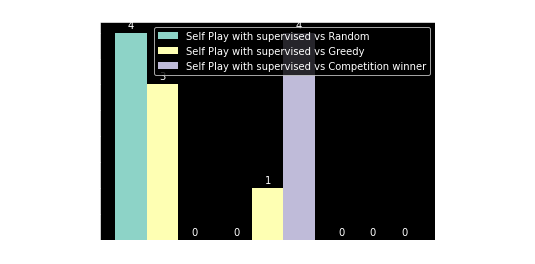

In [36]:
import matplotlib.pyplot as plt

def play_games(num_games, agent1, agent2, agent1_args=None, agent2_args=None):
    agent1_wins = 0
    agent2_wins = 0
    draws = 0

    for i in trange(num_games):
        if i % 2 == 0:
            score = play_game(agent1, agent2, agent1_args, agent2_args, display=False)
        else:
            score = -play_game(agent2, agent1, agent2_args, agent1_args, display=False)

        if score > 0:
            agent1_wins += 1
        elif score < 0:
            agent2_wins += 1
        else:
            draws += 1

    return agent1_wins, agent2_wins, draws


num_games = 4

self_play_vs_random = play_games(num_games, self_play_agent, random_agent, agent1_args=agent_supervised_args)
self_play_vs_greedy = play_games(num_games, self_play_agent, greedy_agent, agent1_args=agent_supervised_args)
self_play_vs_heuristics_agent = play_games(num_games, self_play_agent, self_play_agent, agent1_args=agent_supervised_args, agent2_args=agent_with_heuristics_args)


# Plotting results
x = np.arange(3)
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, self_play_vs_random, width, label='Self Play with supervised vs Random')
rects2 = ax.bar(x, self_play_vs_greedy, width, label='Self Play with supervised vs Greedy')
rects3 = ax.bar(x + width, self_play_vs_heuristics_agent, width, label='Self Play with supervised vs Competition winner')

ax.set_ylabel('Number of Games')
ax.set_title('Self Play Agent Performance against Random, Greedy and Competition Winner Agents')
ax.set_xticks(x)
ax.set_xticklabels(['Wins', 'Losses', 'Draws'])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()


#### Testing Supervised Self Play with Data Augmentation

In [ ]:
model = ResNet( 3, 32, device=device, board_size = board_size, actions_size = actions_size)
model.load_state_dict(torch.load('model_supervised_12.pt', map_location=device))


args = {
    'C': 1.25,
    'num_searches': 500,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth':100
}
mcts = MCTS(model,args, device)
agent_supervised_data_augm_args = {'model': model, 'mcts': mcts, 'args': args}



print("Game between self_play_agent and random_agent:")
play_game(self_play_agent, self_play_agent, agent1_args=agent_supervised_data_augm_args, agent2_args = agent_supervised_args)
# play_game(greedy_agent, self_play_agent, agent2_args=agent_supervised_args)

In [ ]:
num_games = 4

self_play_vs_random = play_games(num_games, self_play_agent, random_agent, agent1_args=agent_supervised_data_augm_args)
self_play_vs_greedy = play_games(num_games, self_play_agent, greedy_agent, agent1_args=agent_supervised_data_augm_args)
self_play_vs_heuristics_agent = play_games(num_games, self_play_agent, self_play_agent, agent1_args=agent_supervised_data_augm_args, agent2_args=agent_with_heuristics_args)
self_play_vs_supervised_wo_data_augmentation = play_games(num_games, self_play_agent, self_play_agent, agent1_args=agent_supervised_data_augm_args, agent2_args=agent_supervised_args)

# Plotting results
x = np.arange(3)
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 3*width/2, self_play_vs_random, width, label='Data Augmentation vs Random')
rects2 = ax.bar(x - width/2, self_play_vs_greedy, width, label='Data Augmentation vs Greedy')
rects3 = ax.bar(x + width/2, self_play_vs_heuristics_agent, width, label='Data Augmentation vs Competition Winner')
rects4 = ax.bar(x + 3*width/2, self_play_vs_supervised_wo_data_augmentation, width, label='Data Augmentation vs No Data Augmentation')

ax.set_ylabel('Number of Games')
ax.set_title('Self Play Agent with Supervised and Data Augmentation Performance')
ax.set_xticks(x)
ax.set_xticklabels(['Wins', 'Losses', 'Draws'])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()


### Increase Model Architecture Test

In [ ]:
import time

model = ResNet( 6, 64, device=device, board_size = board_size, actions_size = actions_size)
# model.load_state_dict(torch.load('model_1.pt', map_location=device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer.load_state_dict(torch.load('optimizer_1.pt', map_location=device))

args = {
    'C': 2,
    'num_searches': 300,
    'num_iterations': 3,
    'start_iteration': 10,
    'num_selfPlay_iterations': 100,
    'num_epochs': 5,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
#     'max_depth':100
}

alphaZero = AlphaZero_Supervised(model, optimizer, args)

start_time = time.time()
memory_ = alphaZero.learn()
end_time = time.time()

time_difference = end_time - start_time
print(f'The code took {time_difference:.2f} seconds to run.')


In [ ]:
model_big_model = ResNet( 6, 64, device=device, board_size = board_size, actions_size = actions_size)
model_big_model.load_state_dict(torch.load('model_supervised_bigger_model_2.pt', map_location=device))


args = {
    'C': 1.25,
    'num_searches': 500,
    'action_size': actions_size,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3, 
    'max_depth':100
}
mcts_big_model = MCTS(model_big_model,args, device)
agent_supervised_bigger_model = {'model': model_big_model, 'mcts': mcts_big_model, 'args': args}

## model with data augmentation
model_big_model_dt_aug = ResNet( 6, 64, device=device, board_size = board_size, actions_size = actions_size)
model_big_model_dt_aug.load_state_dict(torch.load('model_supervised_bigger_model_12.pt', map_location=device))

mcts_big_model_dt_aug = MCTS(model_big_model_dt_aug,args, device)
agent_supervised_bigger_model_dt_aug = {'model': model_big_model_dt_aug, 'mcts': mcts_big_model_dt_aug, 'args': args}




print("Game between self_play_agent and random_agent:")
play_game(greedy_agent, self_play_agent, agent1_args=None, agent2_args = agent_supervised_args)
# play_game(greedy_agent, self_play_agent, agent2_args=agent_supervised_args)

In [ ]:
num_games = 4

self_play_vs_random = play_games(num_games, self_play_agent, random_agent, agent1_args=agent_supervised_bigger_model)
self_play_vs_greedy = play_games(num_games, self_play_agent, greedy_agent, agent1_args=agent_supervised_bigger_model)
self_play_vs_heuristics_agent = play_games(num_games, self_play_agent, self_play_agent, agent1_args=agent_supervised_bigger_model, agent2_args=agent_with_heuristics_args)
self_play_vs_supervised_wo_data_augmentation = play_games(num_games, self_play_agent, self_play_agent, agent1_args=agent_supervised_bigger_model, agent2_args=agent_supervised_args)

# Plotting results
x = np.arange(3)
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 3*width/2, self_play_vs_random, width, label='Bigger Model vs Random')
rects2 = ax.bar(x - width/2, self_play_vs_greedy, width, label='Bigger Model vs Greedy')
rects3 = ax.bar(x + width/2, self_play_vs_heuristics_agent, width, label='Bigger Model vs Competition Winner')
rects4 = ax.bar(x + 3*width/2, self_play_vs_supervised_wo_data_augmentation, width, label='Bigger Model vs Non Bigger Model')

ax.set_ylabel('Number of Games')
ax.set_title('Self Play Agent with Supervised and Data Augmentation Performance')
ax.set_xticks(x)
ax.set_xticklabels(['Wins', 'Losses', 'Draws'])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()
